In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
def define_boundary(nl):
    """Define 1x1 Square region uniformly discretized in 4*nl elements.

    Parameters
    ----------
    nl : int
        Number of elements per side.

    Returns
    -------
    xb : numpy.ndarray[float]
        X coordinate of boundary node points.
    yb : numpy.ndarray[float]
        Y coordinate of boundary node points.
    bt : numpy.ndarray[int]
        Boundary condition type by element.
    bv : numpy.ndarray[float]
        Boundary condition value by element.
    """

    # y = 0 and 0 ≤ x ≤ 1.
    xb1 = np.linspace(0, 1, nl+1)[:-1]
    yb1 = np.zeros(nl+1)[:-1]
    bt1 = np.ones(nl, dtype=np.int8)
    bv1 = np.zeros(nl)
    
    # x = 1 and 0 ≤ y ≤ 1.
    xb2 = np.ones(nl+1)[:-1]
    yb2 = np.linspace(0, 1, nl+1)[:-1]
    bt2 = np.zeros(nl, dtype=np.int8)
    ym = np.linspace(0.5/nl, 1-0.5/nl, nl)
    bv2 = np.cos(np.pi*ym)

    # y = 1 and 0 ≤ x ≤ 1.
    xb3 = np.linspace(1, 0, nl+1)[:-1]
    yb3 = np.ones(nl+1)[:-1]
    bt3 = np.ones(nl, dtype=np.int8)
    bv3 = np.zeros(nl)
    
    # x = 0 and 0 ≤ y ≤ 1.
    xb4 = np.zeros(nl+1)
    yb4 = np.linspace(1, 0, nl+1)
    bt4 = np.zeros(nl, dtype=np.int8)
    bv4 = np.zeros(nl)

    xb = np.concatenate((xb1, xb2, xb3, xb4))
    yb = np.concatenate((yb1, yb2, yb3, yb4))
    bt = np.concatenate((bt1, bt2, bt3, bt4))
    bv = np.concatenate((bv1, bv2, bv3, bv4))
    
    return xb, yb, bt, bv

def compute_elements_properties(xb, yb):
    """Compute elements midpoints, lengths and unit normal vectors.

    Returns
    -------
    xm : numpy.ndarray[float]
        X coordinate of elements midpoints.
    ym : numpy.ndarray[float]
        Y coordinate of elements midpoints.
    lm : numpy.ndarray[float]
        Length of elements.
    nx : numpy.ndarray[float]
        X component of element normal vector.
    ny : numpy.ndarray[float]
        Y component of element normal vector.
    """

    n = len(xb) - 1
    xm, ym, lm, nx, ny = [np.empty(n) for _ in range(5)]
    for i in range(n):
        xm[i] = 0.5*(xb[i] + xb[i + 1])
        ym[i] = 0.5*(yb[i] + yb[i + 1])
        lm[i] = np.sqrt((xb[i+1] - xb[i])**2 + (yb[i + 1] - yb[i])**2)
        nx[i] = (yb[i+1] - yb[i]) / lm[i]
        ny[i] = (xb[i] - xb[i+1]) / lm[i]

    return xm, ym, lm, nx, ny

In [3]:
def intf(t, xi, eta, xk, yk, nkx, nky, lk):
    """Integrand of F."""

    return np.log((xk - t*lk*nky - xi)**2 + (yk + t*lk*nkx - eta)**2)

def intg(t, xi, eta, xk, yk, nkx, nky, lk):
    """Integrand of G."""

    return (nkx*(xk - t*lk*nky - xi) + nky*(yk + t*lk*nkx - eta)) / ((xk - t*lk*nky - xi)**2 + (yk + t*lk*nkx - eta)**2)

def findfg(xi, eta, xk, yk, nkx, nky, lk):
    """Functions F and G"""

    F = (lk/(4.0*np.pi)) * quad(lambda t: intf(t, xi, eta, xk, yk, nkx, nky, lk), 0, 1, epsabs=1e-8)[0]
    G = (lk/(2.0*np.pi)) * quad(lambda t: intg(t, xi, eta, xk, yk, nkx, nky, lk), 0, 1, epsabs=1e-8)[0]

    return F, G

def solve_bem(xb, yb, bt, bv, xm, ym, lm, nx, ny):
    """Build and solve system of equations.

    Returns
    -------
    u : numpy.ndarray[float]
        Function at the boundaries.
    q : numpy.ndarray[float]
        Derivative at the boundaries.
    """

    n = len(xb) - 1
    b = np.zeros(n)
    A = np.zeros((n,n))
    for m in range(n):
        for k in range(n):
            if k == m:
                G = 0.0
                F = lm[k]/(2.0*np.pi) * (np.log(lm[k]/2.0) - 1.0)
                d = 1.0
            else:
                F, G = findfg(xm[m], ym[m], xb[k], yb[k], nx[k], ny[k], lm[k])
                d = 0.0
            if bt[k] == 0:
                A[m, k] = -F
                b[m] = b[m] + bv[k]*(-G + 0.5*d)
            else:
                A[m, k] = G - 0.5*d
                b[m] = b[m] + bv[k]*F
    
    z = np.linalg.solve(A, b)
    
    # Assign approximate boundary values accordingly.
    u, q = [np.empty(n) for _ in range(2)]
    for m in range(n):
        u[m] = (1 - bt[m])*bv[m] + bt[m]*z[m]
        q[m] = (1 - bt[m])*z[m] + bt[m]*bv[m]

    return u, q

In [4]:
def get_domain_values(u, q, xv, yv, xb, yb, nx, ny, lm):
    """Find solution in any part of the domain."""

    n = len(xb) - 1
    s = np.zeros((len(xv), len(yv)))
    for i, x in enumerate(xv):
        for j, y in enumerate(yv):
            for k in range(n):
                [F, G] = findfg(x, y, xb[k], yb[k], nx[k], ny[k], lm[k])
                s[j, i] = s[j, i] + u[k]*G - q[k]*F

    return s

In [5]:
def get_bem_solution(nl, xv, yv):
    """Using 4*nl elements, provides the solution for given points."""
    
    # Pre-processing.
    xb, yb, bt, bv = define_boundary(nl)
    xm, ym, lm, nx, ny = elements_properties(xb, yb)

    # Processing.
    u, q = solve_bem(xb, yb, bt, bv, xm, ym, lm, nx, ny)

    # Post-processing.
    s = get_domain_values(u, q, xv, yv, xb, yb, nx, ny, lm)

    return s

In [6]:
xv = np.linspace(0.01, 0.99, 99)
yv = np.linspace(0.01, 0.99, 99)
xx, yy = np.meshgrid(xv, yv)

# Analytical solution.
u_exact = lambda x, y: np.sinh(np.pi*x) * np.cos(np.pi*y) / np.sinh(np.pi)
ua = u_exact(xx, yy)

# BEM solution for nl = 1 — 25
nlv = np.arange(1,26)
nv = 4*nlv
# sv = np.array([get_bem_solution(nl, xv, yv) for nl in nlv]) # This takes a long time.
sv = np.load("sv.npy")  # Loading from file, instead.
svdict = dict(zip(nv, sv))

abserr = np.max(np.abs(sv - ua), axis=(1,2))

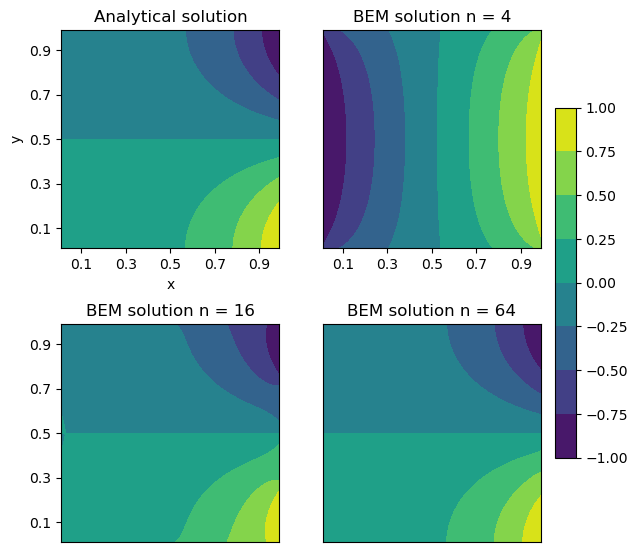

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(7,7))

cont = axes[0, 0].contourf(xx, yy, ua)
axes[0, 0].set_title('Analytical solution')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[0, 0].set_aspect('equal')
axes[0, 0].set_xticks(np.linspace(0.1, 0.9, 5))
axes[0, 0].set_yticks(np.linspace(0.1, 0.9, 5))

nvalues = [4, 16, 64]
for n, ax in zip(nvalues, axes.flatten()[1:]):
    ax.contourf(xx, yy, svdict[n])
    ax.set_title(f'BEM solution n = {n}')
    ax.set_aspect('equal')
    ax.set_xticks(np.linspace(0.1, 0.9, 5))
    ax.set_yticks(np.linspace(0.1, 0.9, 5))

axes[0, 1].yaxis.set_visible(False)
axes[1, 0].xaxis.set_visible(False)
axes[1, 1].xaxis.set_visible(False)
axes[1, 1].yaxis.set_visible(False)

fig.subplots_adjust(right=0.81)
cbar_ax = fig.add_axes([0.83, 0.25, 0.03, 0.5])
fig.colorbar(cont, cax=cbar_ax)

plt.savefig('analytical_bem_comparison.svg', bbox_inches='tight')
plt.show()

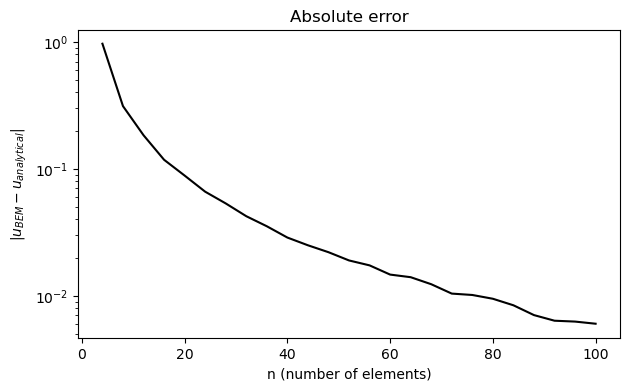

In [8]:
plt.figure(figsize=(7, 4))
plt.semilogy(nv, abserr, 'k')
plt.xlabel('n (number of elements)')
plt.ylabel(r'$|u_{BEM} - u_{analytical}|$')
plt.title('Absolute error')

plt.savefig('abserr.svg', bbox_inches='tight')
plt.show()